# This is a sample script for running baseline and manifold model
## It contains main methods for:
### 1. Training suits
### 2. Manifold learning
### 3. Visualization 

In [1]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import Config
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC

import sklearn.manifold as skm 
import sklearn.utils.random as skr # for random sampling 


In [2]:
# train data 
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config):
    train_acc = []
    test_acc = []
    # Early stopping 
    epsilon = 0.001
    counter = 0
    for _ in tqdm_notebook(range(param["epochs"]), desc='epochs'):
        train_acc.append(hdc.fit(traindata, trainlabels, param))
        test_acc.append(hdc.test(testdata, testlabels))
        if len(train_acc) % 5 == 0:
            print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
        if train_acc[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
            break
        if max(test_acc) - test_acc[-1] >= epsilon:
            counter += 1
            #if counter >= 20:
            #    sys.stderr.write("Early stopping initiated")
            #    print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
            #    break
        else:
            counter = 0
    return np.asarray(train_acc), np.asarray(test_acc)

In [3]:
def dump_log(param, train_acc, test_acc, filename):
    #joblib.dump((param, train_acc, test_acc), open(filename+".pkl", "wb"), compress=True)
    file = open(filename+".txt", "a")
    msg = str(100*max(train_acc)) + " " + str(100*max(test_acc)) + " " +\
        str(len(train_acc)) + " " + str(np.argmax(test_acc) + 1) + "\n"
    file.write(msg)
    file.close()

In [4]:
############### ISOMAP ########################
# Tips from: https://stackoverflow.com/questions/43763362/obtaining-the-size-of-the-neighborhood-in-isomap-algorithm
# Everyone uses a neighborhood size of 8-12.
# If your manifold is more than 2-3 dimensional, then Isomap probably won't work, 
# you would need to have a neighborhood size that is larger (more points!) so that 
# you have reasonable options to estimate your geodesic path with links to nearby neighbors.

def iso_wrapper(n_neighbors, n_components):
    
    start = time.time()
    isomap = skm.Isomap(n_neighbors, n_components)
    isomap.fit(manifolddata)
    end = time.time()
    # Preparation time 
    prep_time = int(end - start) 
    print( "Prep time: ", prep_time ) 
    
    start = time.time()
    trainiso = isomap.transform(traindata)
    testiso = isomap.transform(testdata)
    end = time.time() 
    # Transformation time
    trans_time = int(end-start)
    print( "Transform time: ", trans_time )

    filename = "./dumper/isomap_data_"+str(n_neighbors)+"_"+str(n_components)+".pkl"
    joblib.dump((trainiso, trainlabels, testiso, testlabels), open(filename, "wb"), compress=True)
    
    return trainiso, testiso, prep_time, trans_time

In [5]:
############### Modified/Hessian Locally Linear Embedding , more ########################

def lle_wrapper(n_neighbors, n_components, manifolddata, traindata, testdata, lle_type = "modified"):
    
    start = time.time()
    lle = skm.LocallyLinearEmbedding(n_neighbors, n_components, method = lle_type)
    lle.fit(manifolddata)
    end = time.time()
    prep_time = int(end - start) 
    print( prep_time ) 

    start = time.time()
    trainlle = lle.transform(traindata)
    testlle = lle.transform(testdata)
    end = time.time()
    trans_time = int(end-start)
    print( trans_time )

    #filename = "./dumper/"+lle_type+"_data_"+str(n_neighbors)+"_"+str(n_components)+".pkl"
    #joblib.dump((trainlle, trainlabels, testlle, testlabels), open(filename, "wb"), compress=True)

    return trainlle, testlle, prep_time, trans_time

In [6]:
################# VANILLA #################
def vanilla_train(param, traintrans, trainlabels, testtrans, testlabels):
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    bid = hdb.getParam()["id"]
    # Update param with bid
    param = hdb.getParam()
    print(bid)

    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traintrans)
    #trainencoded = hde.encodeData(traindata)
    #HDE.saveEncoded(trainencoded, trainlabels, bid, "train")
    
    testencoded = hde.encodeData(testtrans)
    #testencoded = hde.encodeData(testdata)
    #HDE.saveEncoded(testencoded, testlabels, bid, "test")

    train_accs = []
    test_accs = []
    # Every encoding is automatically done iter_per_encoding times. 
    for i in range(param["iter_per_encoding"]):
        hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
        train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    return train_accs, test_accs


In [7]:
############### Spectral Embedding ########################
############### Multi-dimensional Scaling ########################
############### t-distributed Stochastic Neighbor Embedding #######
# No online learning version; has to input full data

# Start

In [8]:
# Data loading

dl = DL.Dataloader()
nFeatures, nClasses, traindata, trainlabels, testdata, testlabels = dl.getParam()

Loading dataset UCIHAR from UCIHAR
Loading train data... train data of shape (6213, 561) loaded
Loading test data...  test  data of shape (1554, 561) loaded
Data Loaded. Num of features = 561 Num of Classes = 12

In [9]:
# Data shuffling 
shuf_train = np.random.permutation(len(traindata))
traindata = traindata[shuf_train]
trainlabels = trainlabels[shuf_train]

shuf_test = np.random.permutation(len(testdata))
testdata = testdata[shuf_test]
testlabels = testlabels[shuf_test]

In [10]:
# Data cropping, if needed 
traindata = traindata[:20000]
trainlabels = trainlabels[:20000]
testdata = testdata[: 10000]
testlabels = testlabels[: 10000]

In [11]:
# Reconfirm configuration
param = Config.config
param["nFeatures"] = nFeatures
param["nClasses"] = nClasses
print(param)

{'data_location': '../dataset/', 'directory': 'UCIHAR', 'dataset': 'UCIHAR', 'D': 3000, 'vector': 'Gaussian', 'mu': 0, 'sigma': 1, 'binarize': 0, 'lr': 0.037, 'sparse': 0, 's': 0.1, 'binaryModel': 0, 'width': None, 'height': None, 'nLayers': 5, 'uniform_dim': 1, 'uniform_ker': 1, 'dArr': None, 'k': 5, 'kArr': None, 'one_shot': 0, 'data_percentages': [1.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 'train_percent': 1, 'dropout': 0, 'drop_percentages': [0, 0.1, 0.2, 0.5], 'dropout_rate': 0, 'update_type': <Update_T.FULL: 1>, 'iter_per_trial': 2, 'iter_per_encoding': 2, 'epochs': 250, 'nFeatures': 561, 'nClasses': 12}


In [12]:
############################### MLLE Train ###################################
## Param needed to be specified: D, n_Features, n_neighbors, n_components, "manifold"
## To train other LLE:
## 1. change param["manifold"] to ‘standard’, ‘hessian’, ‘modified’ or ‘ltsa’
## 2. call LLE_wrapper with correct lle_type argument (‘standard’, ‘hessian’, ‘modified’ or ‘ltsa’)
## 3. ensure that n_neighbors, n_components, and maniset_size follows the contraints, or else scikit will complain.


# Best MLLE param for arbitrary D is currently (n_Features, n_neighbors) = (100, 40)
n_neighbors = 100
n_components  = 40
maniset_size = 500        # Size of the manifold set
param["manifold"] = "modified" # MLLE training tag
    
    
# Random sampling for building manifold 
manifoldlist = skr.sample_without_replacement(len(traindata), maniset_size)
manifolddata = np.asfarray(traindata[np.asarray(manifoldlist)])

# update parameter; nFeatures now is equal to n_component 
param["nFeatures"] = n_components

# Build manifold and transform the data
traintrans, testtrans, prep_time, trans_time = lle_wrapper(n_neighbors, n_components, \
                                                           manifolddata, traindata, testdata, \
                                                           "modified")

# Train; accuracy is returned
train_accs, test_accs = vanilla_train(param, traintrans, trainlabels, testtrans, testlabels)

# Prepare filename and log manifold time
filename = "./logfile/" + param["manifold"] + "_" +str(param["D"])+"_"+ \
    str(maniset_size) + "_" + param["dataset"]
file = open(filename+"_time.txt","w")
file.write("Preparation time: "+str(prep_time)+" Transform time: "+str(trans_time)+"\n")
file.close()

# Log complete accuracy results
for i in range(len(train_accs)):     
    dump_log(param, train_accs[i], test_accs[i], filename)

# Log simple accuracy results
file = open(filename+".txt", "a")
max_train_accs = [max(train_acc) for train_acc in train_accs]
max_test_accs = [max(test_acc) for test_acc in test_accs]
msg = str(100*np.mean(max_train_accs)) + " " + str(100*np.mean(max_test_accs)) + "\n"
file.write(msg)
file.close()


4
14


Generating vanilla HD basis of shape... 


3916


(3000, 40)
Encoding time: 0.05116748809814453 
Encoding data of shape (6213, 40)


Time spent: 0 sec
Encoding data of shape (1554, 40)


Time spent: 0 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 0.419926 	 	 Test: 0.214929
Train: 0.521970 	 	 Test: 0.605534
Train: 0.591019 	 	 Test: 0.416988
Train: 0.597457 	 	 Test: 0.605534
Train: 0.634959 	 	 Test: 0.729730
Train: 0.682601 	 	 Test: 0.745174
Train: 0.704491 	 	 Test: 0.857786
Train: 0.719459 	 	 Test: 0.815315
Train: 0.730404 	 	 Test: 0.684685
Train: 0.791888 	 	 Test: 0.798584
Train: 0.744890 	 	 Test: 0.650579
Train: 0.776758 	 	 Test: 0.782497
Train: 0.761629 	 	 Test: 0.742600
Train: 0.784645 	 	 Test: 0.893822
Train: 0.769516 	 	 Test: 0.703990
Train: 0.809915 	 	 Test: 0.833977
Train: 0.777724 	 	 Test: 0.723938
Train: 0.783679 	 	 Test: 0.782497
Train: 0.777241 	 	 Test: 0.770914
Train: 0.804603 	 	 Test: 0.552767
Train: 0.824079 	 	 Test: 0.714286
Train: 0.836472 	 	 Test: 0.902831
Train: 0.814260 	 	 Test: 0.743887
Train: 0.842749 	 	 Test: 0.781853
Train: 0.808788 	 	 Test: 0.821107
Train: 0.834058 	 	 Test: 0.766409
Train: 0.842910 	 	 Test: 0.794723
Train: 0.835023 	 	 Test: 0.891248
Train: 0.829873 	 	 

Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 0.345405 	 	 Test: 0.148005
Train: 0.522453 	 	 Test: 0.372587
Train: 0.564301 	 	 Test: 0.296010
Train: 0.619347 	 	 Test: 0.693050
Train: 0.661033 	 	 Test: 0.798584
Train: 0.709641 	 	 Test: 0.772844
Train: 0.672461 	 	 Test: 0.511583
Train: 0.695799 	 	 Test: 0.776062
Train: 0.712860 	 	 Test: 0.821750
Train: 0.734428 	 	 Test: 0.698842
Train: 0.767262 	 	 Test: 0.836551
Train: 0.777885 	 	 Test: 0.868726
Train: 0.776919 	 	 Test: 0.769627
Train: 0.770320 	 	 Test: 0.655727
Train: 0.762434 	 	 Test: 0.851995
Train: 0.750040 	 	 Test: 0.828185
Train: 0.799936 	 	 Test: 0.851995
Train: 0.816997 	 	 Test: 0.871943
Train: 0.829068 	 	 Test: 0.905405
Train: 0.785450 	 	 Test: 0.773488
Train: 0.805730 	 	 Test: 0.842986
Train: 0.810076 	 	 Test: 0.877735
Train: 0.833897 	 	 Test: 0.740026
Train: 0.829873 	 	 Test: 0.803732
Train: 0.828102 	 	 Test: 0.840412
Train: 0.840657 	 	 Test: 0.855212
Train: 0.838725 	 	 Test: 0.878378
Train: 0.805247 	 	 Test: 0.781853
Train: 0.830034 	 	 

In [14]:
############################### Baseline Train ###################################
## Param needed to be specified: D, nFeatures

# The dummy manifold part
param["nFeatures"] = nFeatures
param["manifold"] = "baseline" # No manifold

# The dummy manifold part
traintrans, testtrans, prep_time, trans_time = traindata, testdata, 0, 0

# Train model 
train_accs, test_accs = vanilla_train(param, traintrans, trainlabels, testtrans, testlabels)


# Prepare filename and (dummy) manifold time
filename = "./logfile/" + param["manifold"] + "_" +str(param["D"])+"_"+ \
     "_" + param["dataset"]
file = open(filename+"_time.txt","w")
file.write("Preparation time: "+str(prep_time)+" Transform time: "+str(trans_time)+"\n")
file.close()


# Log complete accuracy results
for i in range(len(train_accs)):     \
    dump_log(param, train_accs[i], test_accs[i], filename)
    
# Log simple accuracy results
file = open(filename+".txt", "a")
max_train_accs = [max(train_acc) for train_acc in train_accs]
max_test_accs = [max(test_acc) for test_acc in test_accs]
msg = str(100*np.mean(max_train_accs)) + " " + str(100*np.mean(max(max_test_accs))) + "\n"
file.write(msg)
file.close()

Generating vanilla HD basis of shape... 


4113


(3000, 561)
Encoding time: 0.1273791790008545 
Encoding data of shape (6213, 561)


Time spent: 4 sec
Encoding data of shape (1554, 561)


Time spent: 1 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 0.893932 	 	 Test: 0.848134
Train: 0.929181 	 	 Test: 0.927928
Train: 0.944310 	 	 Test: 0.927284
Train: 0.956382 	 	 Test: 0.954311
Train: 0.960567 	 	 Test: 0.942728
Train: 0.954772 	 	 Test: 0.951094
Train: 0.964912 	 	 Test: 0.903475
Train: 0.965234 	 	 Test: 0.948520
Train: 0.978915 	 	 Test: 0.957529
Train: 0.968131 	 	 Test: 0.966538
Train: 0.977145 	 	 Test: 0.969755
Train: 0.975696 	 	 Test: 0.963964
Train: 0.969419 	 	 Test: 0.958172
Train: 0.976662 	 	 Test: 0.969112
Train: 0.978754 	 	 Test: 0.974260
Train: 0.979720 	 	 Test: 0.904118
Train: 0.980525 	 	 Test: 0.952381
Train: 0.980042 	 	 Test: 0.958816
Train: 0.980525 	 	 Test: 0.970399
Train: 0.976501 	 	 Test: 0.937580
Train: 0.981812 	 	 Test: 0.971686
Train: 0.981329 	 	 Test: 0.967825
Train: 0.985997 	 	 Test: 0.974260
Train: 0.977145 	 	 Test: 0.974260
Train: 0.983261 	 	 Test: 0.974260
Train: 0.982134 	 	 Test: 0.974903
Train: 0.981329 	 	 Test: 0.973616
Train: 0.980042 	 	 Test: 0.974260
Train: 0.987768 	 	 

Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 0.906164 	 	 Test: 0.934363
Train: 0.931112 	 	 Test: 0.897040
Train: 0.948334 	 	 Test: 0.956242
Train: 0.954933 	 	 Test: 0.960103
Train: 0.957026 	 	 Test: 0.936937
Train: 0.963303 	 	 Test: 0.962033
Train: 0.960084 	 	 Test: 0.957529
Train: 0.962981 	 	 Test: 0.949163
Train: 0.969580 	 	 Test: 0.962033
Train: 0.968453 	 	 Test: 0.967181
Train: 0.971672 	 	 Test: 0.972973
Train: 0.971833 	 	 Test: 0.909910
Train: 0.974569 	 	 Test: 0.972973
Train: 0.971350 	 	 Test: 0.973616
Train: 0.978110 	 	 Test: 0.969112
Train: 0.975696 	 	 Test: 0.959459
Train: 0.976018 	 	 Test: 0.972973
Train: 0.974248 	 	 Test: 0.974260
Train: 0.976018 	 	 Test: 0.962677
Train: 0.976984 	 	 Test: 0.974903
Train: 0.981490 	 	 Test: 0.971042
Train: 0.985514 	 	 Test: 0.972973
Train: 0.981651 	 	 Test: 0.959459
Train: 0.977628 	 	 Test: 0.965251
Train: 0.974248 	 	 Test: 0.951737
Train: 0.979720 	 	 Test: 0.967825
Train: 0.987124 	 	 Test: 0.973616
Train: 0.987285 	 	 Test: 0.907336
Train: 0.988089 	 	 

# Visualization section
###     Generates the projected graphs of the original data vs the manifold-transformed data

In [15]:
def lle_builder(n_neighbors, n_components, manifolddata, lle_type = "modified"):
    
    start = time.time()
    lle = skm.LocallyLinearEmbedding(n_neighbors, n_components, method = lle_type)
    lle.fit(manifolddata)
    end = time.time()
    prep_time = int(end - start) 
    print( prep_time ) 

    start = time.time()
    trainlle = lle.transform(traindata)
    end = time.time()
    trans_time = int(end-start)
    print( trans_time )
    return trainlle

In [16]:
# Configure manifold
n_neighbors = 125
n_components  = 40
maniset_size = 500 

# sampling for manifold 
manifoldlist = skr.sample_without_replacement(len(traindata), maniset_size)
manifolddata = np.asfarray(traindata[np.asarray(manifoldlist)])
    
# train manifold
trainlle = lle_builder(n_neighbors, n_components, manifolddata)

8
15


In [17]:
# get 2D embedding of lle projection
train_lle_embedded = TSNE(n_components=2).fit_transform(trainlle)

In [18]:
# get 2D embedding of baseline projection
train_embedded = TSNE(n_components=2).fit_transform(traindata)

In [19]:
print(train_lle_embedded.shape) 
print(train_embedded.shape) 

(6213, 2)
(6213, 2)


In [20]:
def generate_colorscheme(size):
    val = "0123456789abcdef"
    cmap = []
    for i in range(size):
        s = "#"
        for i in range(6):
            s = s + val[np.random.randint(16)]
        cmap.append(s)
    return cmap

In [21]:
cmap = generate_colorscheme(nClasses)
colors = [cmap[trainlabel] for trainlabel in trainlabels]

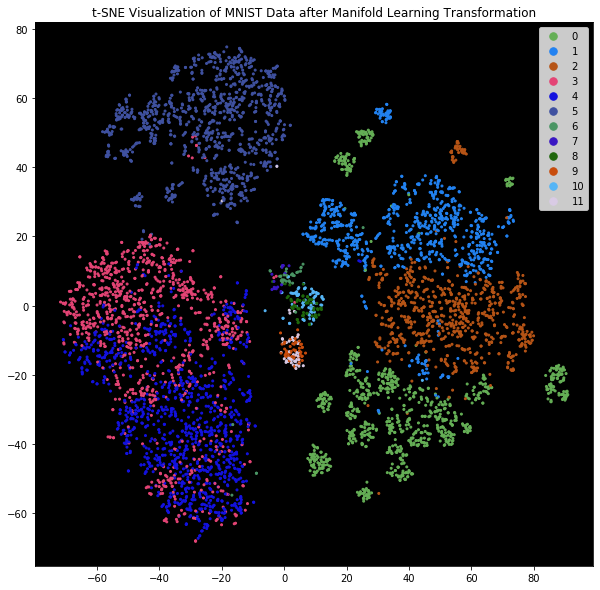

In [22]:
plt.figure(figsize=(10, 10))
plt.title("t-SNE Visualization of MNIST Data after Manifold Learning Transformation")
plt.scatter(train_lle_embedded[:,0], train_lle_embedded[:,1], c = colors, s = 4)

legends = np.asarray([plt.plot([], color = color, marker = ".", markersize = 15, linestyle = "None") for color in cmap])
plt.legend(legends[:,0], list(range(len(cmap))))

ax = plt.gca()
ax.set_facecolor((0, 0, 0))
#plt.savefig('fig/'+clst_type+"_"+str(eps)+"_"+data_type+"_"+str(figsize)+".png")
#plt.clf()
plt.show()

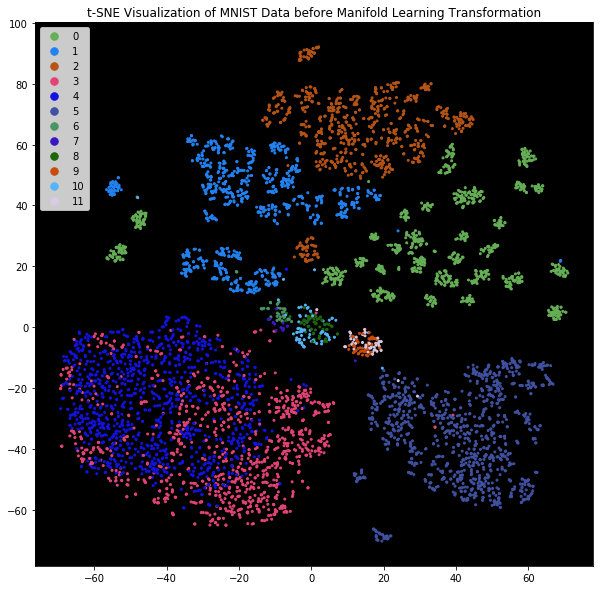

In [23]:
plt.figure(figsize=(10, 10))
plt.title("t-SNE Visualization of MNIST Data before Manifold Learning Transformation")

plt.scatter(train_embedded[:,0], train_embedded[:,1], c = colors, s = 4)


legends = np.asarray([plt.plot([], color = color, marker = ".", markersize = 15, linestyle = "None") for color in cmap])
plt.legend(legends[:,0], list(range(len(cmap))))

ax = plt.gca()
ax.set_facecolor((0, 0, 0))
#plt.savefig('fig/'+clst_type+"_"+str(eps)+"_"+data_type+"_"+str(figsize)+".png")
#plt.clf()
plt.show()

In [24]:
# For saving a randomly generated color that looks nice!
I_like_this_color = cmap
cmap = cmap[:nClasses]